In [13]:
import pandas as pd
import os 
import torch 
import bokeh 
import matplotlib.pyplot as plt
import numpy as np 

from utilities_DL import get_DataSet_and_invalid_dates,get_MultiModel_loss_args_emb_opts
from DL_class import MultiModelTrainer
from config import get_args
from plotting import plot_k_fold_split
from save_results import update_results_df
from paths import folder_path,file_name,get_save_directory

Training and Hyper-parameter tuning with Ray is not possible


In [15]:
# Load config
model_name = 'STGCN' #'CNN'
args = get_args(model_name)
#args = get_args(model_name = model_name,learn_graph_structure = True)  # MTGNN

# Modification : 
args.epochs = 1
args.K_fold = 1

# Save Directory:
save_dir = get_save_directory(args)

In [ ]:
model_param = torch.load(f"{save_dir}best_model_fold0.pkl")

### Load data and Model
**Bien load le dataset après avoir défini appelé args**

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00


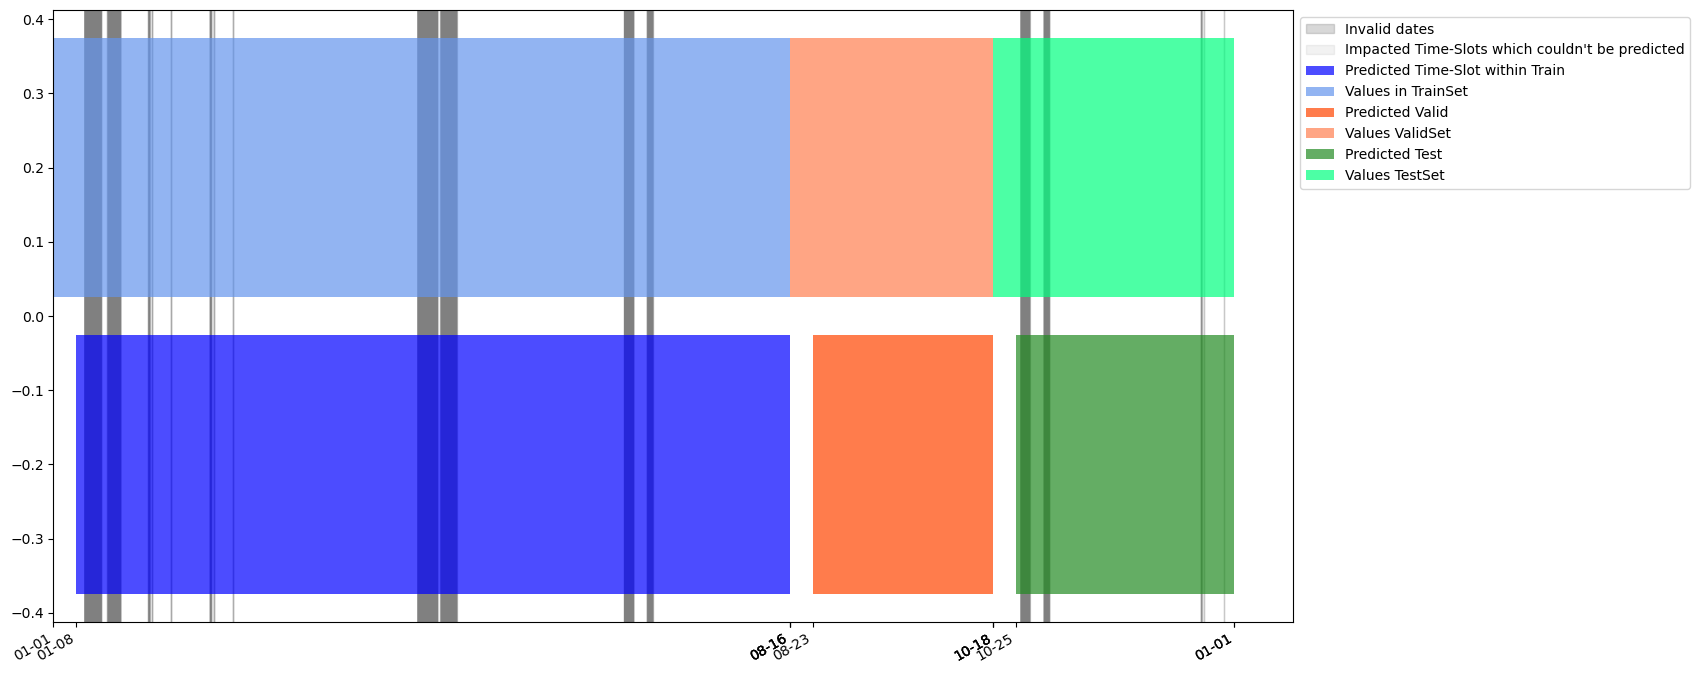

In [103]:
# Load DataSet, plot k_fold split:
dataset,invalid_dates = get_DataSet_and_invalid_dates(folder_path,file_name,
                                                      args.W,args.D,args.H,args.step_ahead,
                                                      single_station = False)
(Datasets,DataLoader_list,time_slots_labels_list,dic_class2rpz_list,dic_rpz2class_list,nb_words_embedding_list) =  dataset.split_K_fold(args,invalid_dates)
plot_k_fold_split(Datasets,invalid_dates)

In [104]:
# Load empty model :
(loss_function,Model_list,Optimizer_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding_list,dic_class2rpz_list)
assert len(Model_list) == 1, "Il y a plus d'un seul model dans la liste, i.e K_fold > 1"

# Associate dict :
model = Model_list[0]
model.load_state_dict(model_param['state_dict'])
data_loader = DataLoader_list[0]
optimizer = Optimizer_list[0]
dic_class2rpz = dic_class2rpz_list[0]

Ko: 8, enable padding: True


# Plot Latent space:

In [105]:
from plotting_bokeh import  generate_bokeh
from DL_class import Trainer

In [106]:
# Load trainer with empty loss_curves ....
# Ca peut être pas mal de sauvegarder la list des valid loss et training loss en plus des états du dictionnaire.
trainer = Trainer(model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)
if len(trainer.train_loss) ==0:
    trainer.train_loss = [0]
    trainer.valid_loss = [0]

#### Calibration:

In [107]:
if False:
    if args.calib_prop is not None:
        Q = trainer.conformal_calibration(args.alpha,dataset,conformity_scores_type =args.conformity_scores_type, quantile_method = args.quantile_method)
        # Plotting, results, and save it in .html file 
else:
        Q = torch.zeros(1,next(iter(data_loader['train']))[0].size(1),1).to(args.device)

In [3]:
import torch
torch.__version__

'1.7.1'

#### Generate bokeh

In [ ]:
#### Point à modifier dans le code:

# === Input Data : 
# Subway_in et Adj ne contenant que 40 colonnes. 
# Il me semble que le bon nombre est 41 (car Fourviere à la fois metro D et à la fois Funiculaire)...
# - Valeur interdites dans Train/Valid qui n'ont pas l'air d'avoir été prise en compte pour test.
# Est-on sur que les valeurs sont belles et bien interdite ? 

# === Plot Bokeh : 
# On aimerait que le plot bokeh soit sur un format datetime, et pas un arange.
# On aimerait un peu plus de précision sur ce qu est plot: un titre pour préciser la station. 
# La légende en dehors du plot
# Le generate bokeh dans le Trainer sur la boucle des epochs se sert d'un Q = 0.
# Peut être faire un Q issus de la calibration choisie pour le model en question ? 

# === Latent Space :
# Soucis sur la représentation de l'espace latent...

# === Metrics : 
# Dans DL_class.MultiModelTrainer, la methode 'k_fold_validation' calcule le PICP et MPIW sur le test-set dans tout les cas. 
# Il ne le fait jamais sur la validation.


In [112]:
trial_save = 'latent_space_Epoch_{epoch}.html'
pi,pi_cqr = generate_bokeh(trainer,data_loader,dataset,Q,args,dic_class2rpz,save_dir,trial_save,station = 0)


/root/anaconda3/envs/torch_rochas/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6038, 40, 1])) that is different to the input size (torch.Size([6038, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/root/anaconda3/envs/torch_rochas/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([6038, 40, 1])) that is different to the input size (torch.Size([6038, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Loading BokehJS ...